# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [1]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [2]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [7]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)
    # print('grads:', grads)
    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")
        # if name == 'W3':
            # print(f'{name} grad:', grads[name][:3])
            # np.save('my_W3.npy', grads[name])
            # his_W3 = np.load('his_W3.npy')
            # print(f"{name} relative error (with my implementation): {rel_error(grad_num, grads[name])}")
            # print(f"{name} relative error (with his implementation): {rel_error(grad_num, his_W3)}")
            # his_numerical = np.load('his_numerical.npy')
            # print(f"{name} relative error (between numerical): {rel_error(grad_num, his_numerical)}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.212047930816777e-05
W3 relative error: 4.5623278145362223e-07
b1 relative error: 4.660094372886962e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.409028728052923e-08
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.1311298702113723e-08
b1 relative error: 1.475242751587128e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 38.844520
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.128000
(Epoch 3 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 4 / 20) train acc: 0.060000; val_acc: 0.091000
(Epoch 5 / 20) train acc: 0.100000; val_acc: 0.078000
(Iteration 11 / 40) loss: 36.841361
(Epoch 6 / 20) train acc: 0.080000; val_acc: 0.102000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.086000


d:\Develop\cs231n\assignment2\cs231n\layers.py:32: RuntimeWarning: overflow encountered in matmul
  out = x.reshape(len(x), -1) @ w + b
d:\Develop\cs231n\assignment2\cs231n\classifiers\fc_net.py:231: RuntimeWarning: overflow encountered in square
  loss += 0.5 * self.reg * np.sum(self.params[f'W{i+1}'] ** 2)
d:\Develop\cs231n\assignment2\cs231n\classifiers\fc_net.py:231: RuntimeWarning: invalid value encountered in scalar multiply
  loss += 0.5 * self.reg * np.sum(self.params[f'W{i+1}'] ** 2)
d:\Develop\cs231n\assignment2\cs231n\classifiers\fc_net.py:240: RuntimeWarning: overflow encountered in square
  loss += 0.5 * self.reg * np.sum(self.params[f'W{i+1}'] ** 2)
d:\Develop\cs231n\assignment2\cs231n\classifiers\fc_net.py:240: RuntimeWarning: invalid value encountered in scalar multiply
  loss += 0.5 * self.reg * np.sum(self.params[f'W{i+1}'] ** 2)
d:\Develop\cs231n\assignment2\cs231n\layers.py:32: RuntimeWarning: invalid value encountered in matmul
  out = x.reshape(len(x), -1) @ w + b

(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 21 / 40) loss: nan
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 17 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 18 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 19 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 20 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 1 / 40) loss: 40.054217
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.14

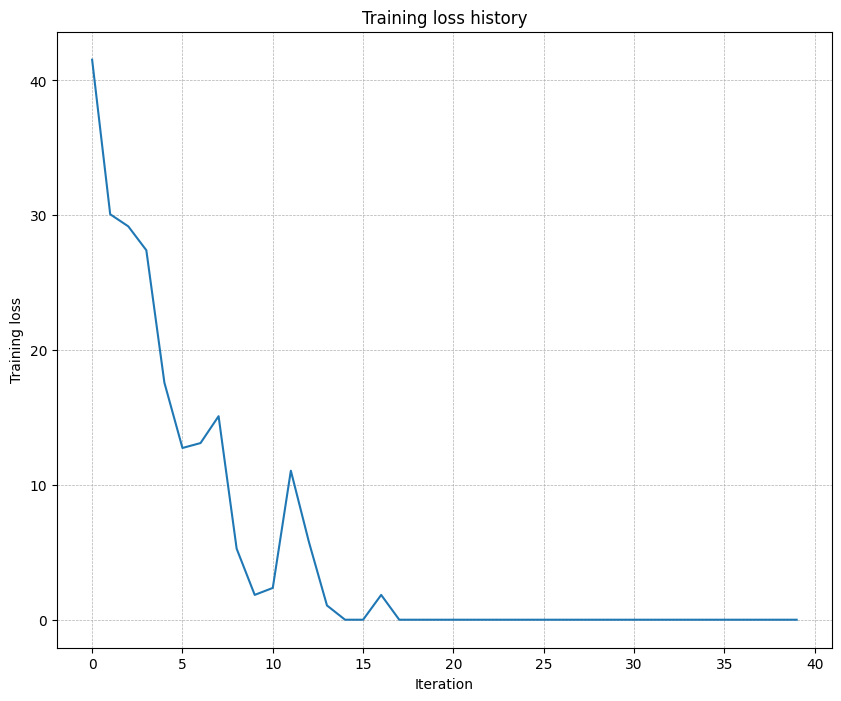

In [9]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

best_acc = -1
best_solver = None
best_model = None
best_lr = 0
best_weight_scale = 0
# weight_scale = 1e-2   # Experiment with this!
# learning_rate = 1e-4  # Experiment with this!
weight_scales = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
learning_rates = [2e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
for weight_scale in weight_scales:
    for learning_rate in learning_rates:
        model = FullyConnectedNet(
          [100, 100],
          weight_scale=weight_scale,
          dtype=np.float64)
        solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule="sgd",
          optim_config={"learning_rate": learning_rate},)
        solver.train()
        if max(solver.train_acc_history) > best_acc:
            best_acc = max(solver.train_acc_history)
            best_model = model
            best_solver = solver
            best_lr = learning_rate
            best_weight_scale = weight_scale
        # plt.plot(solver.loss_history)
        # plt.title("Training loss history")
        # plt.xlabel("Iteration")
        # plt.ylabel("Training loss")
        # plt.grid(linestyle='--', linewidth=0.5)
        # plt.show()

print('best train accuracy:', best_acc)
plt.plot(best_solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()



In [10]:
print('best lr:', best_solver.optim_config['learning_rate'])
print('best acc:', best_acc)

best lr: 0.001
best acc: 1.0


(Iteration 1 / 40) loss: 41.888692
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.109000
(Epoch 1 / 20) train acc: 0.400000; val_acc: 0.156000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.130000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.158000
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.142000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.157000
(Iteration 11 / 40) loss: 3.684159
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.160000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.176000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.176000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.178000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.177000
(Iteration 21 / 40) loss: 2.310851
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.177000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.177000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.177000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.177000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.177000
(Iteration 31 / 40) loss:

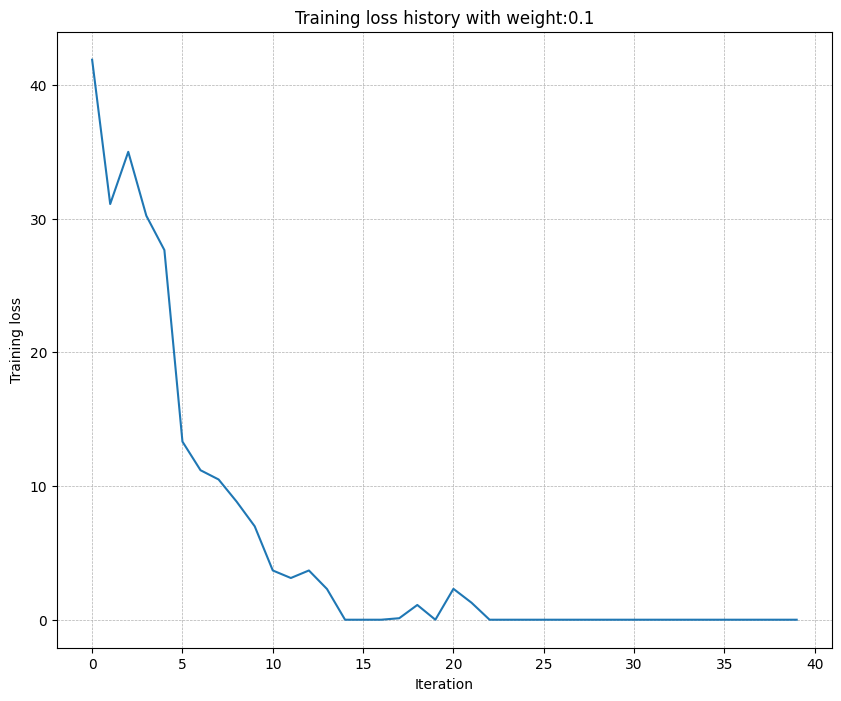

(Iteration 1 / 40) loss: 2.308245
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.092000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.093000
(Epoch 2 / 20) train acc: 0.240000; val_acc: 0.113000
(Epoch 3 / 20) train acc: 0.240000; val_acc: 0.122000
(Epoch 4 / 20) train acc: 0.280000; val_acc: 0.121000
(Epoch 5 / 20) train acc: 0.320000; val_acc: 0.126000
(Iteration 11 / 40) loss: 2.191161
(Epoch 6 / 20) train acc: 0.380000; val_acc: 0.138000
(Epoch 7 / 20) train acc: 0.360000; val_acc: 0.129000
(Epoch 8 / 20) train acc: 0.380000; val_acc: 0.130000
(Epoch 9 / 20) train acc: 0.440000; val_acc: 0.144000
(Epoch 10 / 20) train acc: 0.420000; val_acc: 0.160000
(Iteration 21 / 40) loss: 1.955501
(Epoch 11 / 20) train acc: 0.420000; val_acc: 0.161000
(Epoch 12 / 20) train acc: 0.400000; val_acc: 0.158000
(Epoch 13 / 20) train acc: 0.420000; val_acc: 0.160000
(Epoch 14 / 20) train acc: 0.420000; val_acc: 0.161000
(Epoch 15 / 20) train acc: 0.460000; val_acc: 0.161000
(Iteration 31 / 40) loss: 

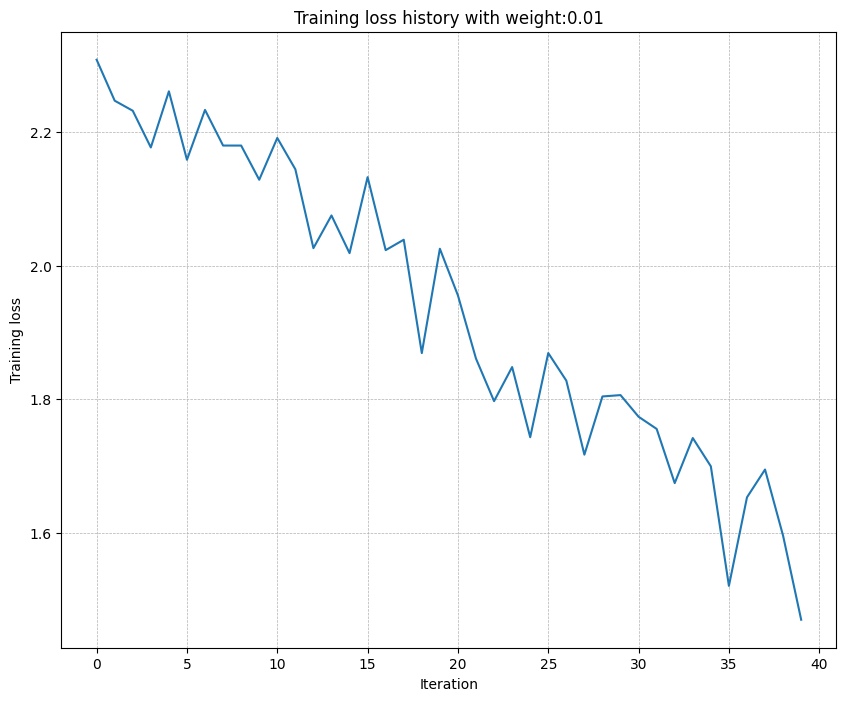

(Iteration 1 / 40) loss: 2.302581
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.090000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.090000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.080000
(Epoch 3 / 20) train acc: 0.260000; val_acc: 0.090000
(Epoch 4 / 20) train acc: 0.220000; val_acc: 0.106000
(Epoch 5 / 20) train acc: 0.180000; val_acc: 0.109000
(Iteration 11 / 40) loss: 2.302347
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.180000; val_acc: 0.111000
(Epoch 8 / 20) train acc: 0.180000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.180000; val_acc: 0.111000
(Epoch 10 / 20) train acc: 0.180000; val_acc: 0.110000
(Iteration 21 / 40) loss: 2.302149
(Epoch 11 / 20) train acc: 0.200000; val_acc: 0.110000
(Epoch 12 / 20) train acc: 0.200000; val_acc: 0.109000
(Epoch 13 / 20) train acc: 0.180000; val_acc: 0.110000
(Epoch 14 / 20) train acc: 0.180000; val_acc: 0.111000
(Epoch 15 / 20) train acc: 0.180000; val_acc: 0.110000
(Iteration 31 / 40) loss: 

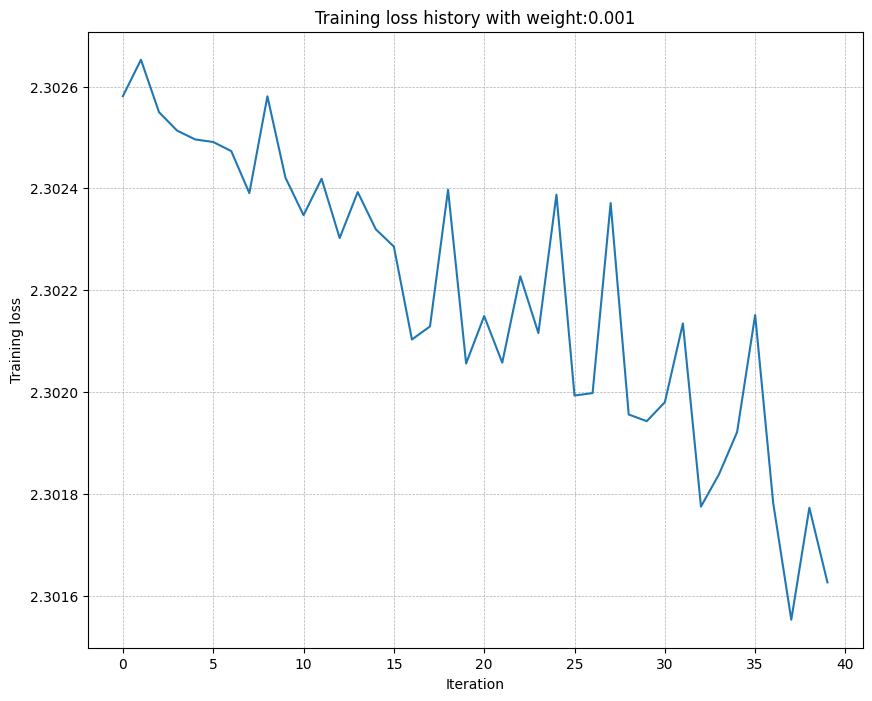

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302492
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302459
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

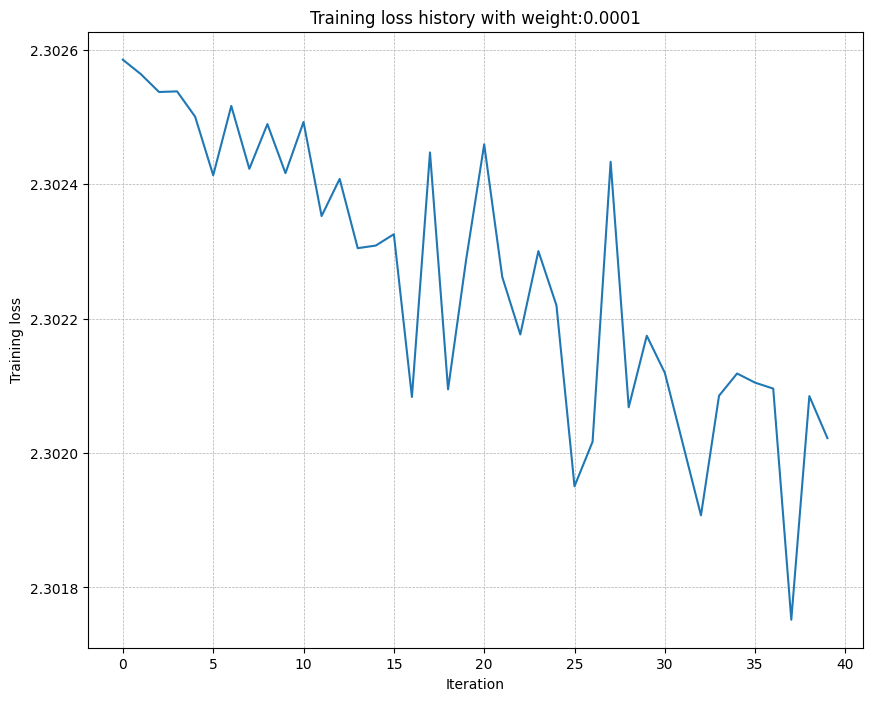

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302425
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302322
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

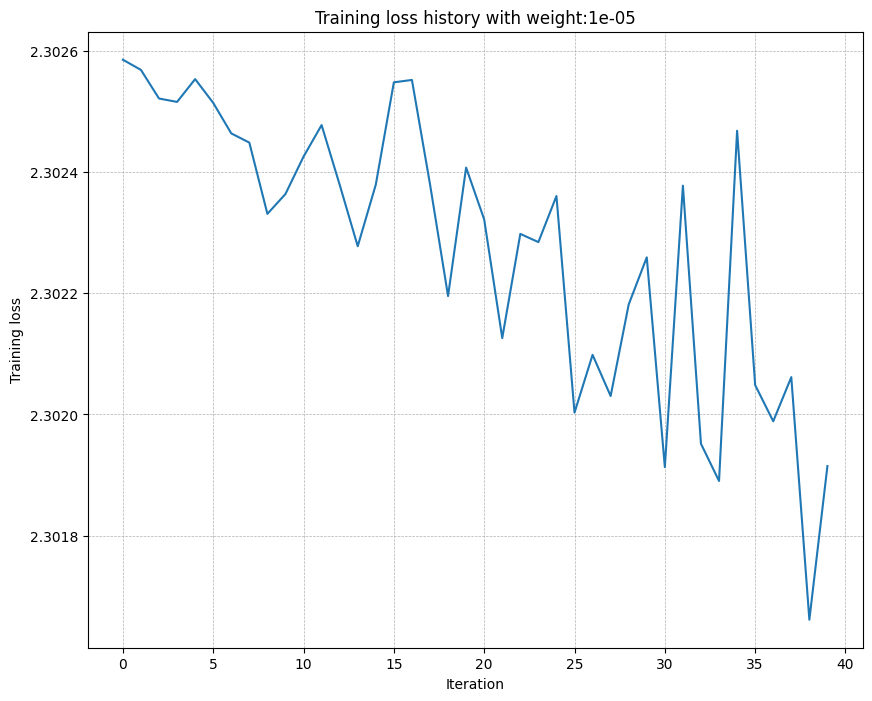

In [11]:
# 我加的代码，测试一下三层网络在给定的lr下，对weight_scale的敏感性
weight_scales = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for weight_scale in weight_scales:
        model = FullyConnectedNet(
          [100, 100],
          weight_scale=weight_scale,
          dtype=np.float64)
        solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule="sgd",
          optim_config={"learning_rate": best_solver.optim_config['learning_rate']},)
        solver.train()
        plt.plot(solver.loss_history)
        plt.title(f"Training loss history with weight:{weight_scale}")
        plt.xlabel("Iteration")
        plt.ylabel("Training loss")
        plt.grid(linestyle='--', linewidth=0.5)
        plt.show()

看上面几幅图发现，很明显，随着weight scale减小，训练的震荡幅度越来越大，能达到的最好的train loss也在不断增大，但从0.001的weight scale开始，效果就差不多了（指差不多差）

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 36.706262
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 3 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 4 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 5 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 11 / 40) loss: nan
(Epoch 6 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 7 / 20) train acc: 0.080000; val_acc: 0.087000


d:\Develop\cs231n\assignment2\cs231n\layers.py:98: RuntimeWarning: invalid value encountered in multiply
  # out = x * (x > 0)


(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 21 / 40) loss: nan
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 17 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 18 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 19 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 20 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 1 / 40) loss: 38.694655
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.078000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.16

d:\Develop\cs231n\assignment2\cs231n\layers.py:158: RuntimeWarning: invalid value encountered in subtract
  shifted_x = x - np.max(x, axis=1, keepdims=True)


(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 17 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 18 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 19 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 20 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 1 / 40) loss: 37.481169
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.115000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.122000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 40.525498
(Epoch 6 / 20) train acc:

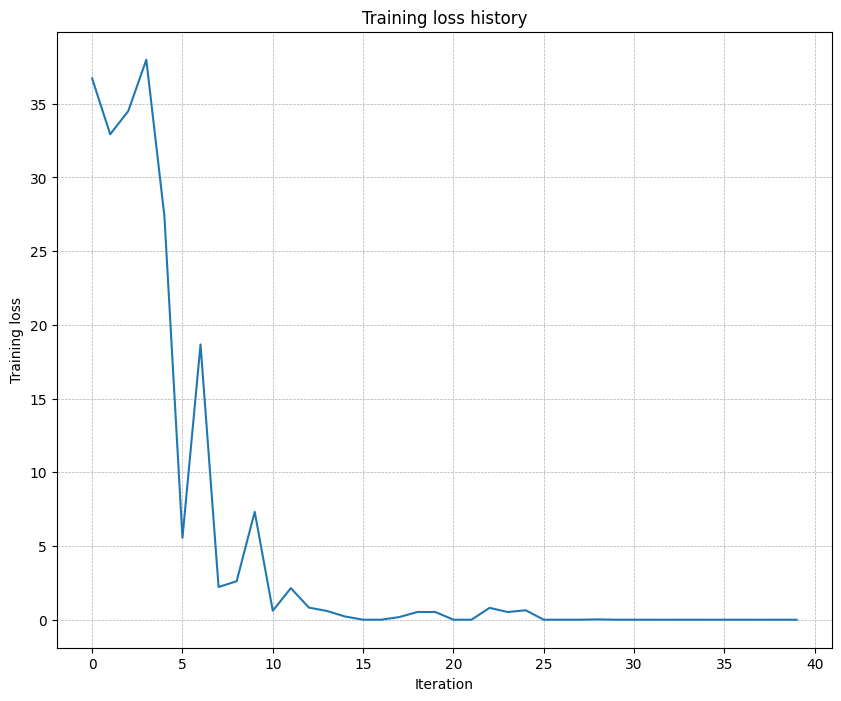

In [12]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


best_acc = -1
best_model = None
best_solver = None
best_lr_5_layer = 0
best_weight_scale_5_layer = 0
weight_scales = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
learning_rates = [2e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
for weight_scale in weight_scales:
    for learning_rate in learning_rates:
        model = FullyConnectedNet(
          [100, 100, 100, 100],
          weight_scale=weight_scale,
          dtype=np.float64
        )
        solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule='sgd',
          optim_config={'learning_rate': learning_rate},
        )
        solver.train()
        # 它要确保这个5层网络也能在50个样本上做到过拟合，那就看看train acc
        if max(solver.train_acc_history) > best_acc:
            best_acc = max(solver.train_acc_history)
            best_model = model
            best_solver = solver
            best_lr_5_layer = learning_rate
            best_weight_scale_5_layer = weight_scale

plt.plot(best_solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [13]:
print(best_acc)
print(best_lr_5_layer)

1.0
0.001


(Iteration 1 / 40) loss: 40.648867
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.092000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.146000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.121000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.139000
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.160000
(Iteration 11 / 40) loss: 6.505680
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.168000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.171000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.174000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.164000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.166000
(Iteration 21 / 40) loss: 0.000424
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.166000
(Iteration 31 / 40) loss:

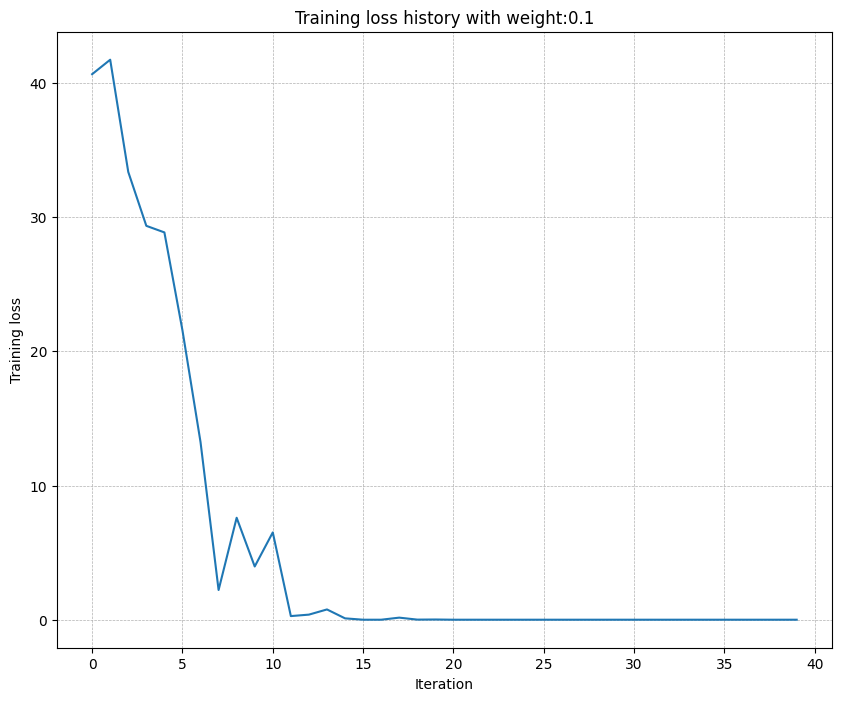

(Iteration 1 / 40) loss: 2.302401
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.124000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.126000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.117000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.116000
(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.118000
(Iteration 11 / 40) loss: 2.301781
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.116000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.113000
(Epoch 8 / 20) train acc: 0.140000; val_acc: 0.105000
(Epoch 9 / 20) train acc: 0.200000; val_acc: 0.115000
(Epoch 10 / 20) train acc: 0.180000; val_acc: 0.117000
(Iteration 21 / 40) loss: 2.301728
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.107000
(Epoch 12 / 20) train acc: 0.180000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.220000; val_acc: 0.120000
(Epoch 14 / 20) train acc: 0.180000; val_acc: 0.118000
(Epoch 15 / 20) train acc: 0.220000; val_acc: 0.121000
(Iteration 31 / 40) loss: 

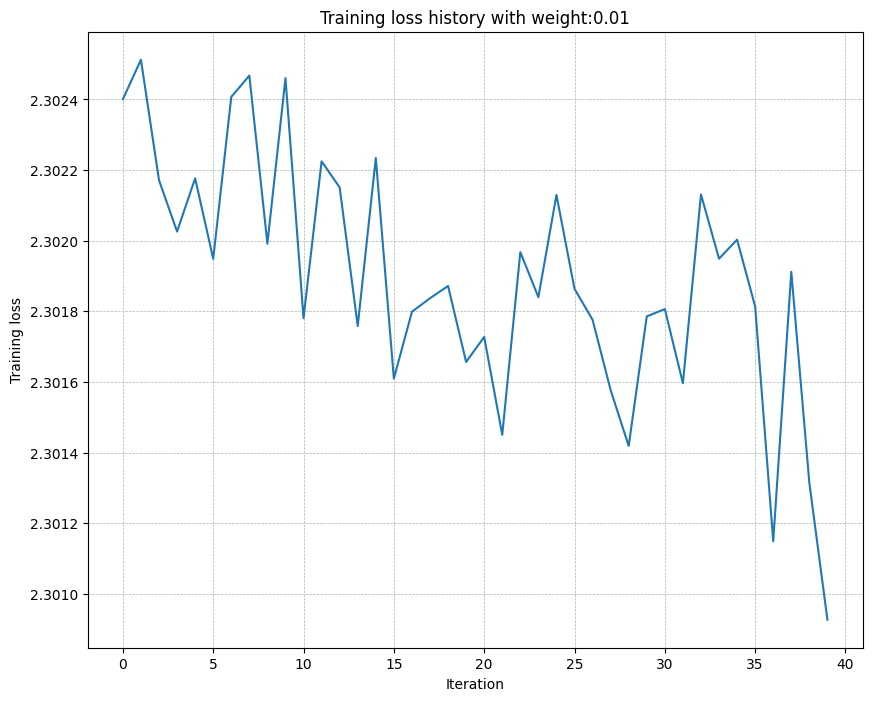

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302369
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302091
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

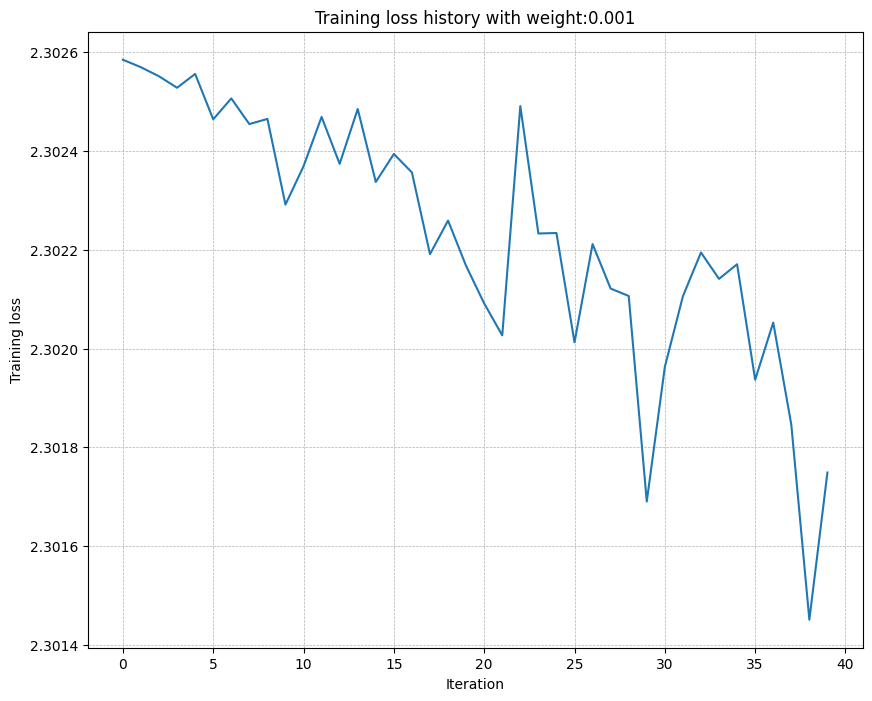

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302416
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302176
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

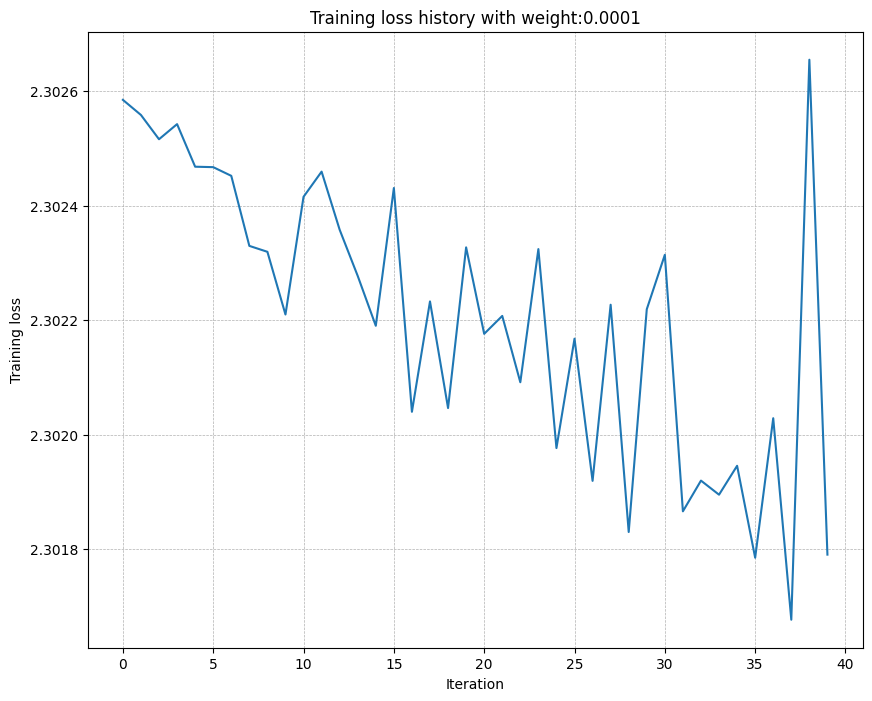

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302229
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.302494
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

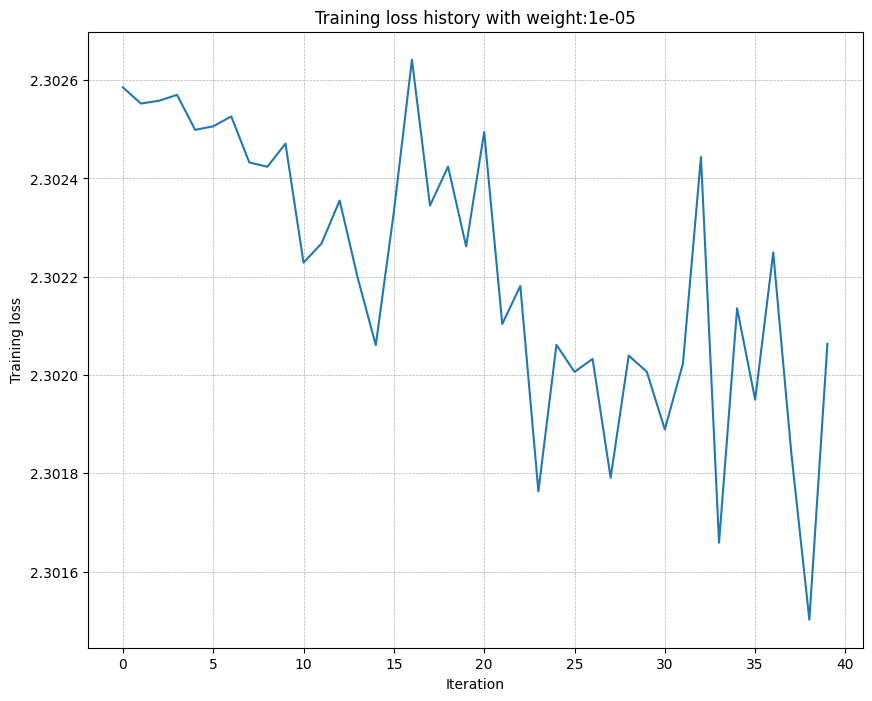

In [14]:
# 我加的代码，测试一下五层网络在给定的lr下，对weight_scale的敏感性
weight_scales = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for weight_scale in weight_scales:
        model = FullyConnectedNet(
          [100, 100, 100, 100],
          weight_scale=weight_scale,
          dtype=np.float64
        )
        solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule='sgd',
          optim_config={'learning_rate': best_lr_5_layer},
        )
        solver.train()
        plt.plot(solver.loss_history)
        plt.title(f"Training loss history with weight:{weight_scale}")
        plt.xlabel("Iteration")
        plt.ylabel("Training loss")
        plt.grid(linestyle='--', linewidth=0.5)
        plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[关于哪个更难训练，感觉不太出来。一来这里数据集很小，很容易过拟合；二来参数的选择范围是一样的，且都达到了训练acc 100%。至于哪个网络对初始的weight scale更敏感，感觉是5层网络。根据上面我给定的最优lr（恰好都是1e-3），然后改变weight scale，看训练的情况，两个网络都随着weight scale的增大，训练过程越发不稳定，但五层网络的不稳定程度，或者看loss曲线的“抖动程度”，相较于三层的，会更大。具体来说，5层网络从0.01的weight scale开始就抖动剧烈，而3层网络大概是从0.001的weight scale开始才抖动剧烈。从这个角度看，应该是五层的更不稳定。直观上看，可能是因为层数比较深，误差的累计会比较大，影响了训练；且这里训练的epoch都不多，只有20个epoch]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 3.249048
(Epoch 0 / 5) train acc: 0.102000; val_acc: 0.087000
(Iteration 11 / 200) loss: 2.448883
(Iteration 21 / 200) loss: 2.355794
(Iteration 31 / 200) loss: 2.314257
(Epoch 1 / 5) train acc: 0.129000; val_acc: 0.127000
(Iteration 41 / 200) loss: 2.232638
(Iteration 51 / 200) loss: 2.198619
(Iteration 61 / 200) loss: 2.194678
(Iteration 71 / 200) loss: 2.250972
(Epoch 2 / 5) train acc: 0.187000; val_acc: 0.161000
(Iteration 81 / 200) loss: 2.182035
(Iteration 91 / 200) loss: 2.238977
(Iteration 101 / 200) loss: 2.134226
(Iteration 111 / 200) loss: 2.157683
(Epoch 3 / 5) train acc: 0.223000; val_acc: 0.178000
(Iteration 121 / 200) loss: 2.111688
(Iteration 131 / 200) loss: 2.124575
(Iteration 141 / 200) loss: 2.160790
(Iteration 151 / 200) loss: 2.137873
(Epoch 4 / 5) train acc: 0.228000; val_acc: 0.195000
(Iteration 161 / 200) loss: 2.126426
(Iteration 171 / 200) loss: 2.185979
(Iteration 181 / 200) loss: 2.090896
(Iteration 191 / 200) los

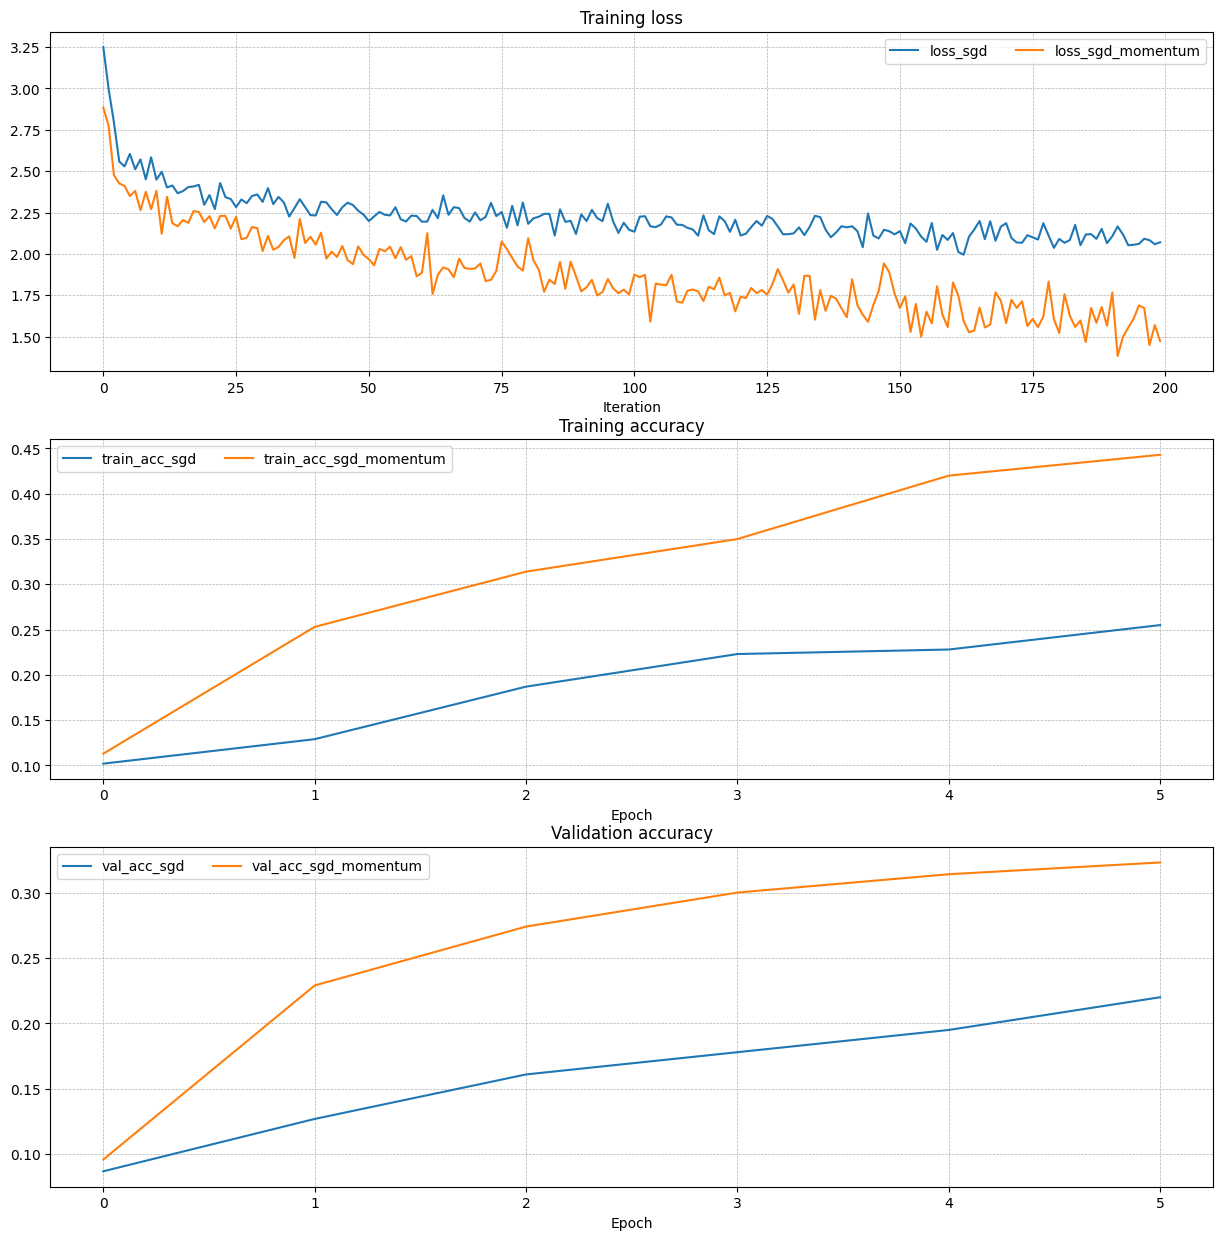

In [17]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 1e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

这回终于出现预期的效果了，即sgd+momentum效果优于单纯的sgd
但weight scale真的很影响效果。如果设置为1e-2，就会发现两种策略下都训的很差，且sgd看起来会优于sgd+momentum

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [18]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [19]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.732233
(Epoch 0 / 5) train acc: 0.125000; val_acc: 0.140000
(Iteration 11 / 200) loss: 2.080945
(Iteration 21 / 200) loss: 1.768248
(Iteration 31 / 200) loss: 1.831447
(Epoch 1 / 5) train acc: 0.381000; val_acc: 0.309000
(Iteration 41 / 200) loss: 1.563416
(Iteration 51 / 200) loss: 1.491067
(Iteration 61 / 200) loss: 1.463201
(Iteration 71 / 200) loss: 1.785254
(Epoch 2 / 5) train acc: 0.457000; val_acc: 0.376000
(Iteration 81 / 200) loss: 1.656452
(Iteration 91 / 200) loss: 1.553775
(Iteration 101 / 200) loss: 1.413336
(Iteration 111 / 200) loss: 1.543815
(Epoch 3 / 5) train acc: 0.507000; val_acc: 0.377000
(Iteration 121 / 200) loss: 1.324575
(Iteration 131 / 200) loss: 1.538124
(Iteration 141 / 200) loss: 1.390694
(Iteration 151 / 200) loss: 1.322337
(Epoch 4 / 5) train acc: 0.548000; val_acc: 0.363000
(Iteration 161 / 200) loss: 1.110322
(Iteration 171 / 200) loss: 1.266117
(Iteration 181 / 200) loss: 1.034612
(Iteration 191 / 200) lo

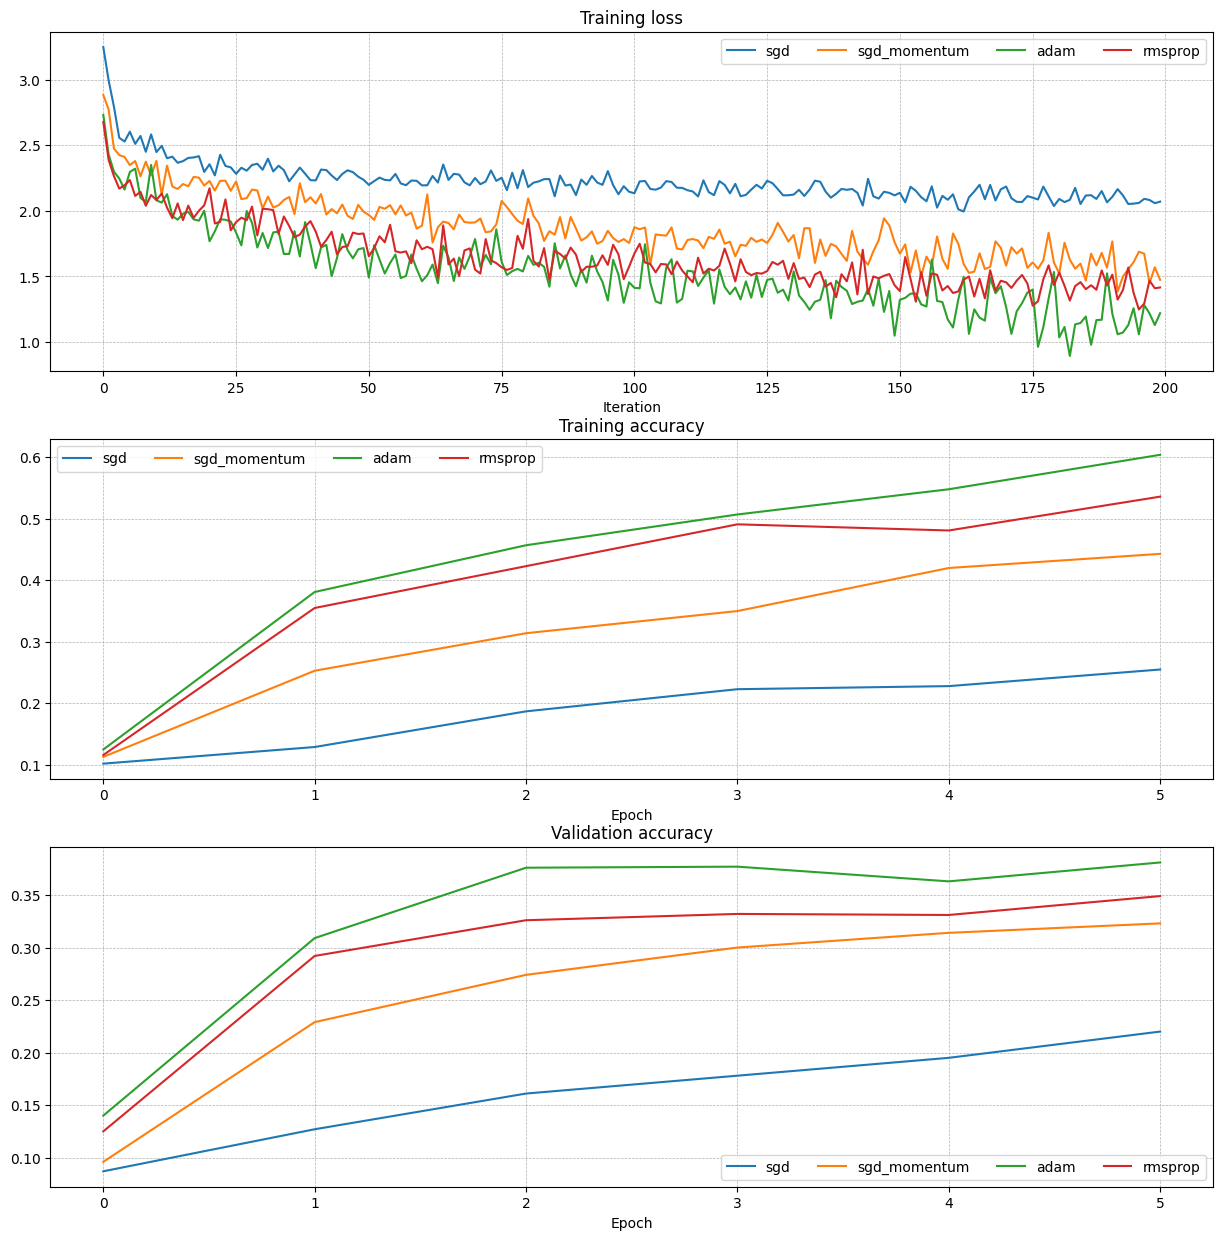

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
[cache里存的累计的梯度平方和是不断增加的，到了后期，这个量级会很大，导致更新的部分过小。Adam一般则不会有这个问题，因为它维护的那个second_momentum（即梯度平方的动态均值），根据它的更新公式（里面对second_momentum有一个衰减的因子），一般不会持续增大]


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [22]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_acc = 0
best_lr = 0
best_weight_scale = 0
best_dropout = 0
best_batch_size = 0
best_solver = None

full_data = {
  "X_train": data["X_train"],
  "y_train": data["y_train"],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}
dropout_choices = [1, 0.75, 0.5, 0.25]
learning_rates = [5e-2, 1e-2, 5e-3, 1e-3, 5e-4]
weight_scales = [1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [20, 50, 70, 100, 150, 300]
for dropout_keep_ratio in dropout_choices:
    for lr in learning_rates:
        for weight_scale in weight_scales:
            for batch_size in batch_sizes:
                model = FullyConnectedNet([100, 120, 140, 120, 100],
                    input_dim=3*32*32,
                    dropout_keep_ratio=dropout_keep_ratio,
                    normalization='batchnorm',
                    reg=0.1,
                    weight_scale=weight_scale,)
                solver = Solver(
                    model,
                    full_data,
                    num_epochs=70,
                    batch_size=batch_size,
                    update_rule='adam',
                    optim_config={'learning_rate': learning_rate,},
                    verbose=True,
                    print_every=100
                    )
                solver.train()
                if max(solver.val_acc_history) > best_acc:
                    best_acc = max(solver.val_acc_history)
                    best_model = model
                    best_solver = solver
                    best_lr = learning_rate
                    best_weight_scale = weight_scale
                    best_dropout = dropout_keep_ratio
                    best_batch_size = batch_size

print('best val accuracy:', best_acc)
plt.plot(best_solver.train_acc_history)
plt.title("Training acc history")
plt.xlabel("Iteration")
plt.ylabel("Training acc")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

plt.plot(best_solver.val_acc_history)
plt.title("Val acc history")
plt.xlabel("Iteration")
plt.ylabel("Val acc")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()
    
    

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 171500) loss: 2.302768
(Epoch 0 / 70) train acc: 0.101000; val_acc: 0.125000
(Iteration 101 / 171500) loss: 2.297246
(Iteration 201 / 171500) loss: 2.265306
(Iteration 301 / 171500) loss: 2.253385
(Iteration 401 / 171500) loss: 2.211141
(Iteration 501 / 171500) loss: 2.182243
(Iteration 601 / 171500) loss: 2.261911
(Iteration 701 / 171500) loss: 2.154481
(Iteration 801 / 171500) loss: 2.130953
(Iteration 901 / 171500) loss: 2.155614
(Iteration 1001 / 171500) loss: 2.153862
(Iteration 1101 / 171500) loss: 2.163152
(Iteration 1201 / 171500) loss: 2.158865
(Iteration 1301 / 171500) loss: 2.174710
(Iteration 1401 / 171500) loss: 2.113378
(Iteration 1501 / 171500) loss: 2.109473
(Iteration 1601 / 171500) loss: 2.012671
(Iteration 1701 / 171500) loss: 2.052133
(Iteration 1801 / 171500) loss: 2.007464
(Iteration 1901 / 171500) loss: 2.016169
(Iteration 2001 / 171500) loss: 2.015029
(Iteration 2101 / 171500) loss: 2.036477
(Iteration 2201 / 171500) loss: 2.113951
(Iteration 2301

KeyboardInterrupt: 

卧槽，我错了，应该在开始训练前先预估一下时间的<br>
以及，我都调了epoch了，那print_every应该相应的增大一点，不然打印的太频繁了（print_every是按iteration算的，epoch多了，batch_size不变时，iteration自然会增多啊）<br>
还有，对调参的量级把握的还不够啊，我还嫌这里调的不够，结果其实已经非常多了。。。

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [23]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.553
Test set accuracy:  0.537


我训了4个多小时，还用的是完整的训练集，也没比别人随机试参数的效果好多少啊。。
还是不能无脑试，得先做点小实验，有点感觉，缩小一下范围